In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gymnasium as gym
import stable_baselines3 as sb3
import stable_baselines3.common.logger as logger
import stable_baselines3.common.callbacks as callbacks
import stable_baselines3.common.env_checker as env_checker
from dm_control import mjcf
from dm_control.rl.control import PhysicsError
import imageio
import scipy.spatial
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric as pyg
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.loader as pyg_loader
import pytorch_lightning as pl
import torchmetrics
from torch.utils.data import Dataset
from pathlib import Path
from typing import Tuple, Callable, Optional, List, Union
from tqdm import trange
from dm_control.rl.control import PhysicsError
from PIL import Image

from flygym.arena.mujoco_arena import FlatTerrain
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.arena.mujoco_arena import OdorArena, FlatTerrain, GappedTerrain, BlocksTerrain
from flygym.util.data import color_cycle_rgb

from rl_navigation import ObstacleOdorArena, NMFNavigation

In [18]:
terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(10, 0)]),
    obstacle_radius=1.5,
    odor_source=np.array([[20, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0.14, 0.14, 0.2, 1),
)
sim = NMFNavigation(
    arena=arena,
    test_mode=True,
    debug_mode=True,
)
# env_checker.check_env(sim)

In [26]:
# from flygym.util.vision import hex_pxls_to_human_readable

terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0)]),
    obstacle_radius=1.5,
    odor_source=np.array([[15, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0, 0, 0, 1),
)
sim = NMFNavigation(
    spawn_pos=(7.5, 10, 0.2),
    spawn_orient=(0, 0, np.pi/4),
    arena=arena,
    test_mode=True,
    debug_mode=True,
)

obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset()
for i in trange(15):
    action = np.array([0 if i < 7 else 0.6])
    action_hist.append(action)
    obs, reward, terminated, truncated, info = sim.step(action)
    # fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    # for i in range(2):
    #     visual_inputs = sim.curr_visual_input[i, :, :]
    #     print(visual_inputs.shape, visual_inputs.max())
    #     visual_inputs[:, 1] = 0
    #     visual_inputs[:, 0][visual_inputs[:, 0] > 50] = 0
    #     img = hex_pxls_to_human_readable(visual_inputs)
    #     axs[i].imshow(img, cmap="gray", vmin=0, vmax=255)
    #     axs[i].axis("off")
    # plt.show()
    
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.save_video("test2.mp4")

resetting environment


  7%|▋         | 1/15 [00:03<00:44,  3.15s/it]

fly_pos: [7.55016389 9.80082426], final reward=3.528131322985713, state=seeking
  dist rew=2.689183, danger=0.000, action diff=0.000, tgt rew=0.839
  dist=12.311


 13%|█▎        | 2/15 [00:06<00:45,  3.51s/it]

fly_pos: [7.58436888 9.69686629], final reward=0.9410170994171781, state=seeking
  dist rew=0.103409, danger=0.000, action diff=0.000, tgt rew=0.838
  dist=12.207


 20%|██        | 3/15 [00:10<00:40,  3.41s/it]

fly_pos: [7.80096725 9.37034946], final reward=1.2232480534184325, state=seeking
  dist rew=0.390914, danger=0.000, action diff=0.000, tgt rew=0.832
  dist=11.816


 27%|██▋       | 4/15 [00:13<00:37,  3.42s/it]

fly_pos: [7.97008265 9.16592413], final reward=1.0860583107985586, state=seeking
  dist rew=0.265134, danger=0.000, action diff=0.000, tgt rew=0.821
  dist=11.551


 33%|███▎      | 5/15 [00:17<00:34,  3.42s/it]

fly_pos: [8.41919943 8.81443941], final reward=1.371448692494662, state=seeking
  dist rew=0.551301, danger=0.000, action diff=0.000, tgt rew=0.820
  dist=11.000


 40%|████      | 6/15 [00:20<00:30,  3.39s/it]

fly_pos: [8.69344738 8.27606962], final reward=1.4050688102076672, state=seeking
  dist rew=0.594966, danger=0.000, action diff=0.000, tgt rew=0.810
  dist=10.405


 47%|████▋     | 7/15 [00:22<00:24,  3.08s/it]

fly_pos: [9.16199836 7.74626627], final reward=1.5019119863498231, state=seeking
  dist rew=0.705251, danger=0.000, action diff=0.000, tgt rew=0.797
  dist=9.700


 53%|█████▎    | 8/15 [00:25<00:21,  3.03s/it]

fly_pos: [9.36843028 7.96693724], final reward=0.44128179461143685, state=seeking
  dist rew=-0.056525, danger=0.000, action diff=0.300, tgt rew=0.798
  dist=9.756


 60%|██████    | 9/15 [00:27<00:16,  2.72s/it]

fly_pos: [9.90662041 8.2610935 ], final reward=0.8480728871908545, state=seeking
  dist rew=0.051306, danger=0.000, action diff=0.000, tgt rew=0.797
  dist=9.705


 67%|██████▋   | 10/15 [00:30<00:13,  2.76s/it]

fly_pos: [9.59210897 7.69102421], final reward=1.0934872382776972, state=seeking
  dist rew=0.303084, danger=0.000, action diff=0.000, tgt rew=0.790
  dist=9.402


 73%|███████▎  | 11/15 [00:33<00:10,  2.74s/it]

fly_pos: [9.71651569 7.05809975], final reward=1.362330868594138, state=seeking
  dist rew=0.585401, danger=0.000, action diff=0.000, tgt rew=0.777
  dist=8.817


 80%|████████  | 12/15 [00:36<00:08,  2.93s/it]

fly_pos: [9.68832062 7.19655699], final reward=0.5189940060249487, state=seeking
  dist rew=-0.127942, danger=0.000, action diff=0.000, tgt rew=0.647
  dist=8.945


 87%|████████▋ | 13/15 [00:40<00:06,  3.11s/it]

fly_pos: [9.62166817 6.174004  ], final reward=1.398723587068995, state=seeking
  dist rew=0.756429, danger=0.000, action diff=0.000, tgt rew=0.642
  dist=8.188


 93%|█████████▎| 14/15 [00:42<00:03,  3.01s/it]

fly_pos: [9.89047098 6.56770694], final reward=0.1141750058992752, state=seeking
  dist rew=-0.133094, danger=0.116, action diff=0.000, tgt rew=0.363
  dist=8.321


100%|██████████| 15/15 [00:46<00:00,  3.11s/it]

fly_pos: [9.36294686 6.22412797], final reward=-0.554556557440353, state=seeking
  dist rew=-0.076207, danger=0.623, action diff=0.000, tgt rew=0.144
  dist=8.397


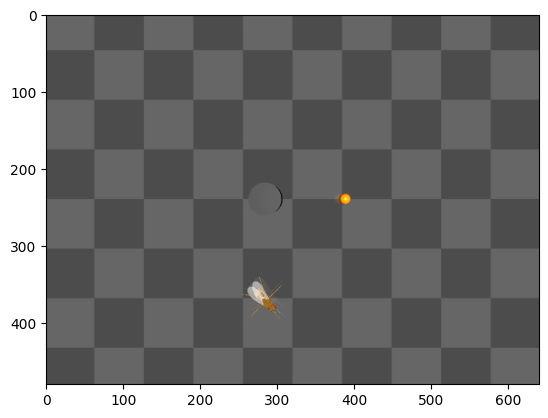

In [5]:
plt.imshow(sim._frames[0])

Logging to logs/trial_8
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
resetting environment


  1%|          | 1/100 [00:03<05:46,  3.50s/it]

fly_pos: [ 0.11538716 -0.0487389 ], final reward=-1.2864676029064726, state=seeking
  dist rew=0.115307, danger=0.673, action diff=0.056, tgt rew=0.000
  dist=14.885


  2%|▏         | 2/100 [00:07<05:46,  3.53s/it]

fly_pos: [ 0.72813338 -0.32689587], final reward=-1.0937037990452438, state=seeking
  dist rew=0.609083, danger=0.851, action diff=0.000, tgt rew=0.000
  dist=14.276


  3%|▎         | 3/100 [00:10<05:56,  3.68s/it]

fly_pos: [ 1.15926423 -0.33281609], final reward=-1.21103243361679, state=seeking
  dist rew=0.430873, danger=0.821, action diff=0.000, tgt rew=0.000
  dist=13.845


  4%|▍         | 4/100 [00:14<05:54,  3.70s/it]

fly_pos: [ 1.52715578 -0.37906213], final reward=-0.5041480029684857, state=seeking
  dist rew=0.366561, danger=0.435, action diff=0.000, tgt rew=0.000
  dist=13.478


  5%|▌         | 5/100 [00:17<05:32,  3.50s/it]

fly_pos: [ 2.22279156 -0.55085386], final reward=-0.8814649897711384, state=seeking
  dist rew=0.689098, danger=0.785, action diff=0.000, tgt rew=0.000
  dist=12.789


  6%|▌         | 6/100 [00:20<05:10,  3.31s/it]

fly_pos: [ 2.77217367 -0.50230311], final reward=-0.3486930003216093, state=seeking
  dist rew=0.550938, danger=0.450, action diff=0.000, tgt rew=0.000
  dist=12.238


  7%|▋         | 7/100 [00:23<05:02,  3.26s/it]

fly_pos: [ 3.33918609 -0.70674723], final reward=-0.5527787363394077, state=seeking
  dist rew=0.555927, danger=0.554, action diff=0.000, tgt rew=0.000
  dist=11.682


  8%|▊         | 8/100 [00:27<05:02,  3.29s/it]

fly_pos: [ 3.82452784 -0.72919977], final reward=-0.7919597579629494, state=seeking
  dist rew=0.482975, danger=0.637, action diff=0.000, tgt rew=0.000
  dist=11.199


  9%|▉         | 9/100 [00:30<04:46,  3.14s/it]

fly_pos: [ 4.32270922 -0.85811583], final reward=-0.29776928615319886, state=seeking
  dist rew=0.487519, danger=0.393, action diff=0.000, tgt rew=0.000
  dist=10.712


 10%|█         | 10/100 [00:32<04:31,  3.02s/it]

fly_pos: [ 4.97004614 -1.02125183], final reward=-0.32883230682134434, state=seeking
  dist rew=0.629906, danger=0.479, action diff=0.000, tgt rew=0.000
  dist=10.082


 10%|█         | 10/100 [00:36<05:26,  3.63s/it]

fly_pos: [ 4.84159934 -0.99434895], final reward=-1.7359851565985904, state=collision
  dist rew=-0.125138, danger=0.368, action diff=0.000, tgt rew=0.000
  dist=10.207
terminated
terminated


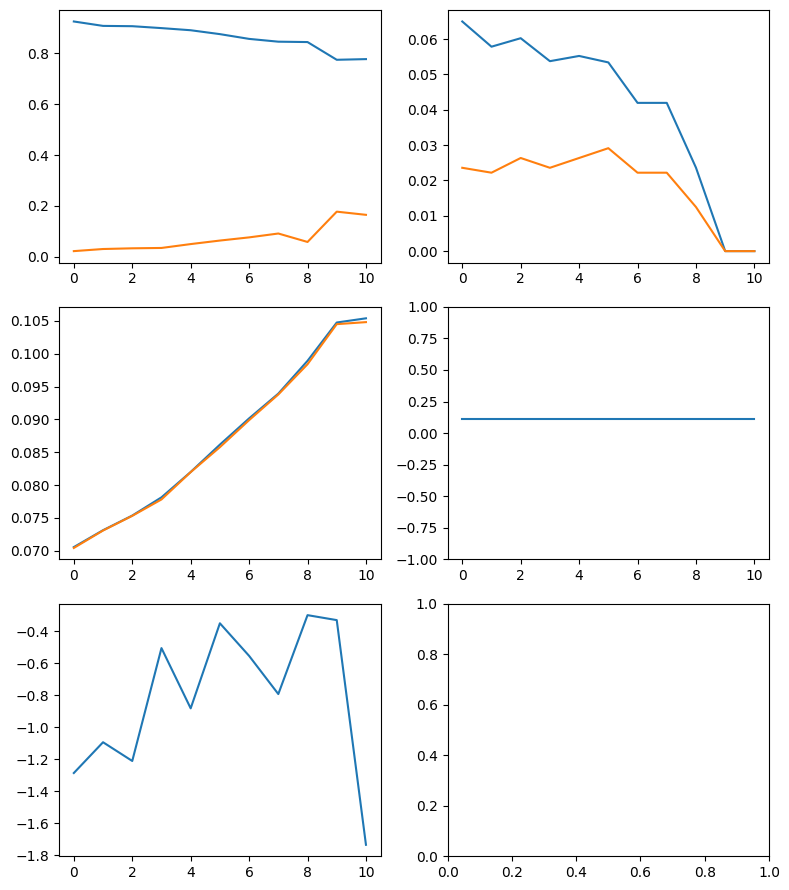

In [27]:
terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0)]),
    obstacle_radius=1,
    odor_source=np.array([[15, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0, 0, 0, 1),
)

sim = NMFNavigation(
    arena=arena,
    test_mode=True,
    debug_mode=True,
)

np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)
start_from = "logs/trial_21/trial_21_88800_steps.zip"
train = False

log_dir = "logs/trial_8"
checkpoint_callback = callbacks.CheckpointCallback(
    save_freq=100,
    save_path=log_dir,
    name_prefix="trial_8",
    save_replay_buffer=True,
    save_vecnormalize=True,
    verbose=2,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC(
    "MlpPolicy",
    # env=sim,
    env=sim,
    policy_kwargs={"net_arch": [16, 16]},
    verbose=2,
    learning_rate=0.01,
)
if start_from is not None:
    model = sb3.SAC.load(start_from)
model.set_logger(my_logger)

if train:
    model.learn(total_timesteps=50_000, progress_bar=True, callback=checkpoint_callback)
    model.save("models/trial_8")

obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset()
for i in trange(100):
    action, _ = model.predict(obs, deterministic=True)    
    obs, reward, terminated, truncated, info = sim.step(action)
    action_hist.append(action)
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.save_video(Path(start_from).stem + ".mp4")

fig, axs = plt.subplots(3, 2, figsize=(8, 9), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 1].plot(obs_hist[:, 2])
axs[0, 1].plot(obs_hist[:, 3])
axs[1, 0].plot(obs_hist[:, 4])
axs[1, 0].plot(obs_hist[:, 5])
axs[1, 1].plot(action_hist)
axs[1, 1].set_ylim(-1, 1)
axs[2, 0].plot(reward_hist)

In [7]:
# sample_interval = 30
# individual_frames_dir = Path("outputs/individual_frames")
# individual_frames_dir.mkdir(parents=True, exist_ok=True)

# offset = max(0, len(sim._frames) % sample_interval - 1)
# # print(len(sim._frames), offset)
# selected_images = np.array(
#     [sim._frames[i] for i in range(offset, len(sim._frames), sample_interval)]
# )
# background = np.median(np.array(sim._frames), axis=0)

# for i in trange(0, selected_images.shape[0]):
#     img = selected_images[i, :, :, :]
#     is_background = np.isclose(img, background, atol=1).all(axis=2)
#     img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
#     img_alpha[:, :, :3] = img
#     img_alpha[is_background, 3] = 0
#     img_alpha = img_alpha.astype(np.uint8)
#     # break
#     imageio.imwrite(
#         individual_frames_dir / f"frame_{i}.png", img_alpha
#     )

# imageio.imwrite(individual_frames_dir / "background.png", background.astype(np.uint8))

100%|██████████| 5/5 [00:00<00:00, 46.10it/s]


In [8]:
len(sim._frames)

147

In [9]:
list(range(offset, len(sim._frames), sample_interval))

[26, 56, 86, 116, 146]